In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import random
import math

np.random.seed(42)

# 模拟参数
timestamps = pd.date_range(start=datetime.now(), periods=120, freq='1min')
# 周期短（sin 中的 40），振幅缩小到 10，噪声也缩小
values = np.sin(np.linspace(0, 40, 120)) * 10 + 50 + np.random.normal(0, 0.5, 120)

# 转成 DataFrame
df = pd.DataFrame({'timestamp': timestamps, 'power': values})
df.set_index('timestamp', inplace=True)

# 可视化
df['power'].plot(title='Shorter Cycle + Smaller Amplitude Power Data')
plt.xlabel("Time")
plt.ylabel("Power (W)")
plt.tight_layout()
plt.show()


NameError: name 'i' is not defined

In [6]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

# Normalize the data
scaler = MinMaxScaler()
power_scaled = scaler.fit_transform(df[['power']])

# Create sequences
def create_sequences(data, input_len=30, output_len=10):
    x, y = [], []
    for i in range(len(data) - input_len - output_len):
        x.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len])
    return np.array(x), np.array(y)

X, y = create_sequences(power_scaled, 30, 10)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)


In [7]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_len=10):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_len)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])  # Take last time step
        return out.unsqueeze(-1)

model = LSTMForecast()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [8]:
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = loss_fn(output, y_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.4121
Epoch 10, Loss: 0.1173
Epoch 20, Loss: 0.0657
Epoch 30, Loss: 0.0148
Epoch 40, Loss: 0.0047
Epoch 50, Loss: 0.0023
Epoch 60, Loss: 0.0010
Epoch 70, Loss: 0.0007
Epoch 80, Loss: 0.0007
Epoch 90, Loss: 0.0006


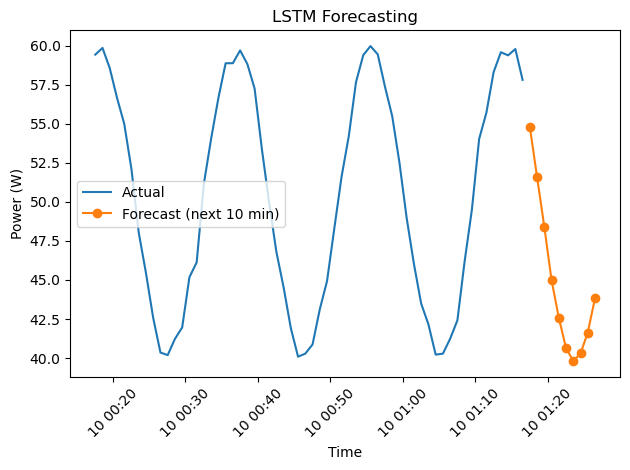

In [13]:
# Take the last 30 minutes of real data
last_seq = torch.tensor(power_scaled[-30:], dtype=torch.float32).unsqueeze(0)

model.eval()
with torch.no_grad():
    prediction = model(last_seq)

# Inverse scale prediction
predicted_power = scaler.inverse_transform(prediction.squeeze(-1).numpy()).flatten()

# Build prediction timestamps
future_times = [df.index[-1] + timedelta(minutes=i+1) for i in range(10)]

plt.plot(df.index[-60:], df['power'][-60:], label='Actual')
plt.plot(future_times, predicted_power, label='Forecast (next 10 min)', marker='o')
plt.title("LSTM Forecasting")
plt.xlabel("Time")
plt.ylabel("Power (W)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
# Save model and scaler
torch.save(model.state_dict(), "lstm_model.pth")